In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import FittingWorkCleaner as FWC
import Neutrino_Work as NW
from classy import Class

In [2]:
data_1= np.load("mass-300-life-0.030.npz", allow_pickle=True)
f_actual = data_1['fe'][-1]
e_actual = data_1['e'][-1]
Neff_short = data_1['neff']

data_2= np.load("mass-300-life-0.584.npz", allow_pickle=True)
f_actual_2 = data_2['fe'][-1]
e_actual_2 = data_2['e'][-1]
Neff_long = data_2['neff']


data_file = np.load("test-fit.npz", allow_pickle=True)
e = data_file['eps']
f = data_file['fe']


data_file2 = np.load("test-fit2.npz", allow_pickle=True)
e2 = data_file2['eps']
f2 = data_file2['fe']

In [4]:
def larger_emax(filename,alpha_num):
    alpha = alpha_num
    
    data_actual = np.load(filename, allow_pickle=True)
    f = data_actual['fe'][-1]
    e = data_actual['e'][-1]
    
    af = data_actual['scalefactors'][-1]
    tf = data_actual['temp'][-1]
    value = 1/(af*tf) 
    
    T,N,coefficients = FWC.finale(e,f,4,False)
    A,B,C,D,E = coefficients[0],coefficients[1],coefficients[2],coefficients[3],coefficients[4]
    
    T_p = T/alpha
    N_p = N
    A_p = A*(alpha)**4
    B_p = B*(alpha)**3
    C_p = C*(alpha)**2
    D_p = D*(alpha)**1
    E_p = E
    value_p = value*alpha
    
    k = len(e)-15
    e_shorter = np.delete(e,np.s_[-k:])
    
    dn = np.zeros(len(e_shorter))
    for i in range(len(e_shorter)):
        dn[i] = (value)**3*(2/(2*np.pi)**3)*(((N/np.exp(e_shorter[i]/T))+1)+np.exp(A*e_shorter[i]**4+B*e_shorter[i]**3+C*e_shorter[i]**2+D*e_shorter[i]+E))*4*(np.pi)**2*(e_shorter[i])**2
        
    
    k_p = len(e)-30
    e_p = np.delete(e,np.s_[-k_p:])
    
    dn_p = np.zeros(len(e_p))
    for i in range(len(e_p)):
        dn_p[i] = (value_p)**3*(2/(2*np.pi)**3)*(((N_p/np.exp(e_p[i]/T_p))+1)+np.exp(A_p*e_p[i]**4+B_p*e_p[i]**3+C_p*e_p[i]**2+D_p*e_p[i]+E_p))*4*(np.pi)**2*(e_p[i])**2
        
    F_p = np.zeros(len(e_p))
    for i in range(len(e_p)):
        F_p[i] = (2/(2*np.pi)**3)*(((N_p/np.exp(e_p[i]/T_p))+1)+np.exp(A_p*e_p[i]**4+B_p*e_p[i]**3+C_p*e_p[i]**2+D_p*e_p[i]+E_p))
        
    plt.figure()
    plt.plot(e_shorter,dn,color="blue")
    plt.plot(e_p,dn_p,color='red')
    plt.show
    
    
    plt.figure()
    plt.plot(alpha*e_p,F_p,color='black')
    plt.show
    
    
    
    
    

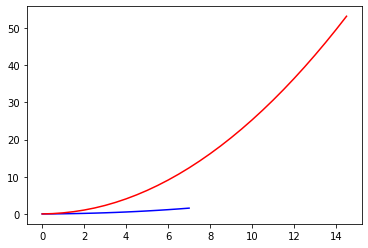

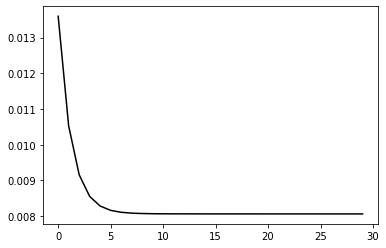

In [14]:
larger_emax("mass-300-life-0.584.npz",2)

In [7]:
def mimic(e,T,N,A,B,C,D,E,T_ncdm):
    dn = np.zeros(len(e))
    for i in range(len(e)):
        dn[i] = (T_ncdm)**3*(2/(2*np.pi)**3)*(((N/np.exp(e[i]/T))+1)+np.exp(A*e[i]**4+B*e[i]**3+C*e[i]**2+D*e[i]+E))*4*(np.pi)**2
    return dn 

    
    

In [16]:
def v_masses_nontherm_alpha(m_small, normal,filename,poly_degree,plot):
    
    #if normal is True, uses the normal hiearachy, If normal False, uses the inverted hiearachy.
    #if plot is true, neutrino spectra is plotted. If false, spectra is not plotted. parameters returned in both 
    
    actual_data= np.load(filename, allow_pickle=True)
    f_array = actual_data['fe'][-1]
    e_array = actual_data['e'][-1]
    alpha = 7
    
    mass1,mass2,mass3 = NW.v_masses(m_small,normal)
    
    T_best,N_best,coefficients = FWC.finale(e_array,f_array,poly_degree,plot)
    
    params = '{},{},{},{},{},{},{}'.format(T_best/alpha,N_best,coefficients[0]*alpha**4,coefficients[1]*alpha**3,coefficients[2]*alpha**2,coefficients[3]*alpha,coefficients[4])
    
    af = actual_data['scalefactors'][-1]
    tf = actual_data['temp'][-1]
    value = (1/(af*tf))*alpha

    
    neutrino_mass_settings = {'N_ncdm':3,
          'use_ncdm_psd_files': "0,0,0",
          'm_ncdm': '{},{},{}'.format(mass1,mass2,mass3),
          'T_ncdm':'{},{},{}'.format(value,value,value),
          'ncdm_psd_parameters': params,
          'N_ur': 0.0
          }   
    
    LambdaCDM_settings = {'omega_b':0.0223828,
                     #'omega_cdm':0.1201075,
                     'h':0.67810,
                     'A_s':2.100549e-09,
                     'n_s':0.9660499,
                     'tau_reio':0.05430842,
                     'output':'mPk',
                     'P_k_max_1/Mpc':3.0,
                      'Omega_m':0.309883043,
                     # The next line should be uncommented for higher precision (but significantly slower running)
                     'ncdm_fluid_approximation':3,
                     # You may uncomment this line to get more info on the ncdm sector from Class:
                     'background_verbose':1,
                    }

    neutrino = Class()
    neutrino.set(LambdaCDM_settings)
    neutrino.set(neutrino_mass_settings)
    neutrino.compute()

    neutrino_results = NW.dict_results(neutrino)
    N_eff = neutrino_results['Neff']   
        
    LambdaCDM_other = {'N_ur':'{},{},{}'.format(N_eff,N_eff,N_eff) #needed to get LambdaCDM Neff closer to model Neff
                     }
    
    LambdaCDM = Class()
    LambdaCDM.set(LambdaCDM_settings)
    LambdaCDM.set(LambdaCDM_other)
    LambdaCDM.compute()
    
    LambdaCDM_results = NW.dict_results(LambdaCDM)
    
    kk = np.logspace(-4,np.log10(3),1000) # k in h/Mpc
    Pk_LambdaCDM = np.zeros(len(kk)) # P(k) in (Mpc/h)**3
    h = LambdaCDM_settings['h'] # get reduced Hubble for conversions to 1/Mpc

    for i,k in enumerate(kk):
        Pk_LambdaCDM[i] = LambdaCDM.pk(k*h,0.)*h**3 # function .pk(k,z)

    
    kk= np.logspace(-4,np.log10(3),1000) # k in h/Mpc
    Pk_neutrino = np.zeros(len(kk))

    for i,k in enumerate(kk):
        Pk_neutrino[i] = neutrino.pk(k*h,0.)*h**3 # function .pk(k,z)
        
    plt.figure()
    plt.loglog(kk,Pk_LambdaCDM)
    plt.loglog(kk,Pk_neutrino,linestyle='--')
    plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
    plt.ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$')
    plt.show()


    plt.figure()
    plt.semilogx(kk,Pk_neutrino/Pk_LambdaCDM-1)
    plt.xlabel(r'$k [h /\mathrm{Mpc}]$')
    plt.ylabel(r'$P(k)^\nu/P(k)-1$')
    plt.show()
    
    
   
    return neutrino_results,LambdaCDM_results

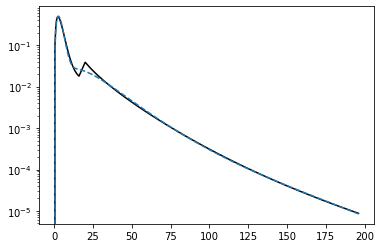

TypeError: argument of type 'NoneType' is not iterable

Exception ignored in: 'classy.Class.__dealloc__'
Traceback (most recent call last):
  File "classy.pyx", line 208, in classy.Class.struct_cleanup
TypeError: argument of type 'NoneType' is not iterable


TypeError: argument of type 'NoneType' is not iterable

Exception ignored in: 'classy.Class.__dealloc__'
Traceback (most recent call last):
  File "classy.pyx", line 208, in classy.Class.struct_cleanup
TypeError: argument of type 'NoneType' is not iterable


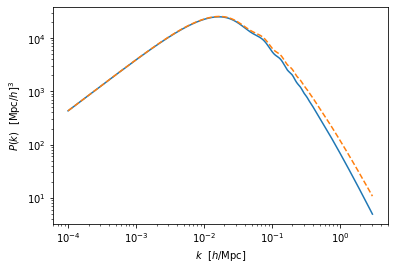

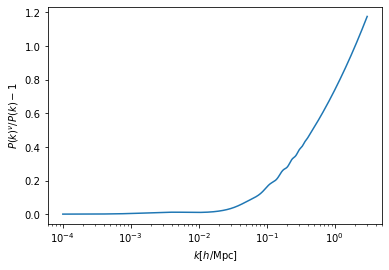

({'age': 13.77253893319659,
  'Neff': 3.103071755961004,
  'omega_b': 0.022382800000000005,
  'Omega0_cdm': 0.2557076496618297,
  'h': 0.6781,
  'Omega0_k': 0.0,
  'Omega0_m': 0.3098825212199531,
  'Omega_b': 0.04867734979810887,
  'Omega_g': 5.378150968509927e-05,
  'Omega_lambda': 0.6900631754903149,
  'Omega_m': 0.3098825212199531,
  'Omega_r': 5.430328973194922e-05,
  'rs_drag': 147.40837774872654,
  'Sigma8': 0.9201607610655993,
  'Sigma8_cb': 0.9343301888721061,
  'T_cmb': 2.7255,
  'theta_s_100': 1.0432580169404313,
  'theta_star_100': 1.0456347036540652,
  'n_s': 0.9660499,
  'tau_reio': 0.05430842},
 {'age': 13.770554244901565,
  'Neff': 3.103071755961004,
  'omega_b': 0.022382800000000005,
  'Omega0_cdm': 0.26120569320189113,
  'h': 0.6781,
  'Omega0_k': 0.0,
  'Omega0_m': 0.309883043,
  'Omega_b': 0.04867734979810887,
  'Omega_g': 5.378150968509927e-05,
  'Omega_lambda': 0.6900252740306985,
  'Omega_m': 0.309883043,
  'Omega_r': 9.168296930146772e-05,
  'rs_drag': 146.775366

In [19]:
v_masses_nontherm_alpha(0.1,True,"mass-300-life-0.584.npz",4,True)

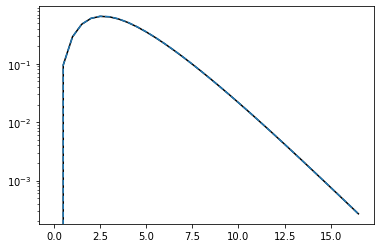

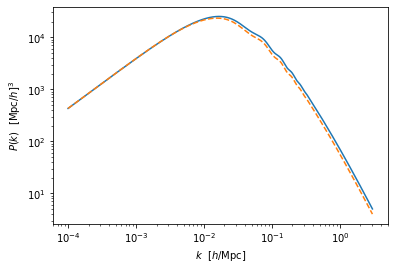

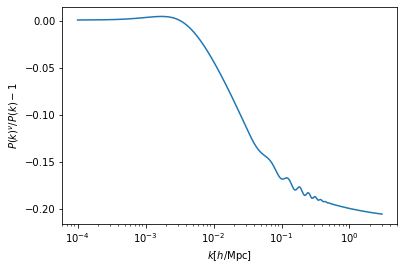

({'age': 13.772636026962244,
  'Neff': 3.009725403938497,
  'omega_b': 0.022382800000000005,
  'Omega0_cdm': 0.25405112471956637,
  'h': 0.6781,
  'Omega0_k': 0.0,
  'Omega0_m': 0.30988279610055197,
  'Omega_b': 0.04867734979810887,
  'Omega_g': 5.378150968509927e-05,
  'Omega_lambda': 0.6900631754903148,
  'Omega_m': 0.30988279610055197,
  'Omega_r': 5.4028409133186665e-05,
  'rs_drag': 148.06173970921395,
  'Sigma8': 0.7521250017614913,
  'Sigma8_cb': 0.7675755866159331,
  'T_cmb': 2.7255,
  'theta_s_100': 1.0477211099115173,
  'theta_star_100': 1.0501164238278078,
  'n_s': 0.9660499,
  'tau_reio': 0.05430842},
 {'age': 13.770622962411778,
  'Neff': 3.009725403938497,
  'omega_b': 0.022382800000000005,
  'Omega0_cdm': 0.26120569320189113,
  'h': 0.6781,
  'Omega0_k': 0.0,
  'Omega0_m': 0.30988304299999997,
  'Omega_b': 0.04867734979810887,
  'Omega_g': 5.378150968509927e-05,
  'Omega_lambda': 0.6900264141793222,
  'Omega_m': 0.30988304299999997,
  'Omega_r': 9.05428206778595e-05,
  '

In [18]:
v_masses_nontherm_alpha(0.1,True,"mass-300-life-0.030.npz",4,True)